# ANALYSIS

In [40]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [77]:
import pandas as pd
import numpy as np
import sklearn
import pyreadr

#statistics
from scipy.stats import chi2_contingency, ttest_ind

import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler


#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, train_test_split

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.svm import SVC #gpu-powered SVM

#Tree pruning
from sklearn.tree._tree import TREE_LEAF


#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

from collections import Counter
import os

In [78]:
# Data loader
# trainingData = pd.read_csv('../FinalData/trainingDataEncoded_08102023.csv')
# validationData = pd.read_csv('../FinalData/validationDataEncoded_08102023.csv')
# evaluationData = pd.read_csv('../FinalData/evaluationDataEncoded_08102023.csv')
# evaluationDataWales = pd.read_csv('../FinalData/evaluationDataWalesEncoded_08102023.csv')
# evaluationDataScotland = pd.read_csv('../FinalData/evaluationDataScotlandEncoded_08102023.csv')

trainingData, validationData, internalEvaluationData, evaluationData, evaluationDataWales, evaluationDataScotland = pickle.load(open('../FinalData/dataset_scaled_01122023.sav', 'rb'))

trainingData = trainingData[(trainingData.age >=8) & (trainingData.age <=80)]
validationData = validationData[(validationData.age >=8) & (validationData.age <=80)]
internalEvaluationData = internalEvaluationData[(internalEvaluationData.age >=8) & (internalEvaluationData.age <=80)]
evaluationData = evaluationData[(evaluationData.age >=8) & (evaluationData.age <=80)]
evaluationDataWales = evaluationDataWales[(evaluationDataWales.age >=8) & (evaluationDataWales.age <=80)]
evaluationDataScotland = evaluationDataScotland[(evaluationDataScotland.age >=8) & (evaluationDataScotland.age <=80)]

trainingData = trainingData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
validationData = validationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
internalEvaluationData = internalEvaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationData = evaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationDataWales = evaluationDataWales.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationDataScotland = evaluationDataScotland.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)

In [79]:
# # Data loader
# trainingData = pd.read_csv('../FinalData/trainingDataEncoded_2vs1_16112023.csv')
# validationData = pd.read_csv('../FinalData/validationDataEncoded_2vs1_16112023.csv')
# internalEvaluationData = pd.read_csv('../FinalData/internalEvaluationDataEncoded_2vs1_16112023.csv')
# evaluationData = pd.read_csv('../FinalData/evaluationDataEncoded_2vs1_16112023.csv')
# evaluationDataWales = pd.read_csv('../FinalData/evaluationDataWalesEncoded_2vs1_16112023.csv')
# evaluationDataScotland = pd.read_csv('../FinalData/evaluationDataScotlandEncoded_2vs1_16112023.csv')

# trainingData = trainingData.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# validationData = validationData.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# internalEvaluationData = internalEvaluationData.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# evaluationData = evaluationData.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# evaluationDataWales = evaluationDataWales.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# evaluationDataScotland = evaluationDataScotland.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)

In [80]:
target_outcomes = ['12months'] 
for target_outcome in target_outcomes:
    print('#######################################################')
    print(target_outcome)
    print(trainingData[target_outcome].value_counts(normalize=True))
    print(validationData[target_outcome].value_counts(normalize=True))
    # print(internalEvaluationData[target_outcome].value_counts(normalize=True))
    print(evaluationData[target_outcome].value_counts(normalize=True))
    print(evaluationDataWales[target_outcome].value_counts(normalize=True))
    print(evaluationDataScotland[target_outcome].value_counts(normalize=True))

#######################################################
12months
0    0.8786
1    0.1214
Name: 12months, dtype: float64
0    0.878263
1    0.121737
Name: 12months, dtype: float64
0    0.831678
1    0.168322
Name: 12months, dtype: float64
0    0.842964
1    0.157036
Name: 12months, dtype: float64
0    0.811635
1    0.188365
Name: 12months, dtype: float64


In [81]:
#Define feature candidates

features_columns = trainingData.columns.to_list()
exclude_columns = ['patid', 'practice_id', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '9months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'cat_age', 'cat_average_daily_dose_ICS', 'cat_prescribed_daily_dose_ICS', 'cat_ICS_medication_possesion_ratio', 'cat_numOCS', 'cat_numOCSEvents', 
                   'cat_numOCSwithLRTI', 'cat_numAcuteRespEvents', 'cat_numAntibioticsEvents', 'cat_numAntibioticswithLRTI', 'cat_numAsthmaAttacks', 'cat_numHospEvents', 
                   'cat_numPCS', 'cat_numPCSAsthma', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                   
                   'numOCSEvents', #duplicate with numOCS
                   
                   'month_12', 'month_4', 'month_5', 'month_10', 'month_1', 'month_6', 'month_3', 
                   'month_11', 'month_8', 'month_9', 'month_7', 'month_2', #month of attacks
                   
                   # 'system_EMIS', 'system_SystemOne', 'system_Vision', #primary care system used
                  ]
exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  67
['sex', 'age', 'CharlsonScore', 'BTS_step', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numOCS', 'PriorEducation', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'ethnic_group_Asian - ethnic group', 'ethnic_group_Black - ethnic group', 'ethnic_group_Mixed ethnic census group', 'ethnic_group_Other ethnic group', 'ethnic_group_White - ethnic group', 'ethnic_group_not_recorded', 'smokingStatus_Active Smoker', 'smokingStatus_Former Smoker', 'smokingStatus_Non Smoker', 'DeviceType_BAI', 'DeviceType_DPI', 'DeviceType_NEB', 'DeviceType_pMDI', 'DeviceType_unknown', 'cat_BMI_normal', 'cat_BMI_not recorded', 'cat_BMI_obese', 'cat_BMI_overweight', 'cat_BMI_underweight', 'imd_decile_0', 'imd_decile_1', 

# UTILS

In [82]:
#Model evaluation function

def summariseResult (testX, testY, model):
    preds = model.predict_proba(testX)
    preds = [x[1] for x in preds]
    # tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    # specificity = tn / (tn+fp)
    # sensitivity = tp / (tp+fn)
    # ppv = 100*tp/(tp+fp)
    # npv = 100*tn/(fn+tn)
    # acc = accuracy_score(testY, preds)
    # f1score = f1_score(testY, preds, average = 'binary')
    # balanceacc = balanced_accuracy_score(testY, preds)
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    # aucscore = auc(fpr, tpr)
    aucscore = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(aucscore,4), np.round(auprc,4)
    # return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)

#Fix model name for visualisation

def modelNameFixer(x):
    if 'liblinear' in x:
        return 'Lasso'
    elif 'GaussianNB' in x:
        return 'GNB'
    elif 'SVC' in x:
        return 'SVC'
    elif 'RandomForest' in x:
        return 'RF'
    elif 'XGB' in x:
        return 'XGBoost'
    elif 'DecisionTree' in x:
        return 'DT'
    else:
        return 'LR'
    
    
# instantiate the model (using the default parameters)
def build_models (X_train, y_train, target_outcome, params_dict, model_fodler, fold):
    models = [] #list to store all the models
    print("Building models . . . .")

    #LR
    model = 'LR'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    lr_model = LogisticRegression(class_weight='balanced', C = params['C'], max_iter=params['max_iter'], solver=params['solver'], random_state=1234)
    lr_model.fit(X_train,y_train)
    pickle.dump(lr_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]]) 
    print("LR done")

    #Lasso
    model = 'Lasso'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    lasso_model = LogisticRegression(class_weight='balanced',  C = params['C'], max_iter=params['max_iter'], penalty='l1', solver=params['solver'], random_state=1234) #only the LIBLINEAR and SAGA (added in v0.19) solvers handle the L1 penalty
    lasso_model.fit(X_train, y_train)
    pickle.dump(lasso_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("Lasso done")
    
    #Elastics
    model = 'Elastics'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    elastics_model = LogisticRegression(class_weight='balanced', solver='saga', l1_ratio=params['l1_ratio'], max_iter=params['max_iter'],  penalty = 'elasticnet', random_state=1234)
    elastics_model.fit(X_train, y_train)
    pickle.dump(elastics_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("Elastics done")

    # #GNB
    # model = 'NB'
    # params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # # params = eval(params)
    # print(params)
    # gnb_model = GaussianNB(var_smoothing = params['var_smoothing'])
    # gnb_model.fit(X_train, y_train)
    # pickle.dump(gnb_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))  
    # models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    # print("GNB done")

    # # #SVM
    # model = 'SVM'
    # params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # # params = eval(params)
    # print(params)
    # svc_model = SVC(class_weight='balanced', C = params['C'], gamma=params['gamma'], kernel='rbf', random_state=1234, cache_size=1000)
    # svc_model.fit(X_train,y_train)
    # pickle.dump(svc_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb')) 
    # models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    # print("SVM done")

    #DT
    model = 'DT'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=params['max_depth'], criterion=params['criterion'], splitter=params['splitter'], random_state=1234)
    dt_model.fit(X_train, y_train)
    pickle.dump(dt_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))    
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("DT done")

    #RF
    model = 'RF'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    rf_model = RandomForestClassifier(class_weight='balanced', max_depth=params['max_depth'], criterion=params['criterion'], n_estimators=params['n_estimators'], random_state=1234)
    rf_model.fit(X_train, y_train)
    pickle.dump(rf_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))     
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("RF done")

    #XGB
    model = 'XGB'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    scale_pos_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
    xgb_model = xgb.XGBClassifier(objective ='binary:logistic', max_depth = params['max_depth'], n_estimators = params['n_estimators'],   
                                  learning_rate=params['learning_rate'], reg_alpha = params['reg_alpha'], reg_lambda = params['reg_lambda'],
                                  importance_type = 'gain', scale_pos_weight = scale_pos_ratio, use_label_encoder=False, tree_method='gpu_hist', 
                                  gpu_id=0, verbosity = 0, random_state = 1234,)
    # xgb_model = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.001, tree_method='gpu_hist', gpu_id=0,  verbosity = 0, random_state = 1234)
    xgb_model.fit(X_train,y_train)
    pickle.dump(xgb_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb')) 
    models.append([model + str(fold),  target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("XGB done")
    
    return models
    # return [xgb_model]

    


def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

# Train Model

In [83]:
X = trainingData[features_columns]
X_val = validationData[features_columns]
X = pd.concat([X, X_val])

X_internaleval = internalEvaluationData[features_columns]
X_eval = evaluationData[features_columns]
X_eval_Wales = evaluationDataWales[features_columns]
X_eval_Scotland = evaluationDataScotland[features_columns]

print(X.shape)
print(X_val.shape)
print(X_eval.shape)
print(X_eval_Wales.shape)
print(X_eval_Scotland.shape)

target_outcomes = ['3months', '6months', '12months', '24months'] 
# target_outcomes = ['12months'] 
model_names = ['LR', 'Lasso', 'NB', 'DT', 'RF', 'XGB']

(510272, 67)
(121393, 67)
(23859, 67)
(15264, 67)
(8595, 67)


In [84]:
#params
params_dict = pd.read_csv('../Models/BS_new.csv')

In [85]:
def process_params(param_items, best_param):
    a = eval(param_items)
    b = eval(best_param)
    c = {}
    for key, value in zip(a,b):
        c[key] = value
    return c

params_dict['params'] = params_dict.apply(lambda x: process_params(x.param_items, x.best_param), axis=1)

In [86]:
params_dict.head()

,outcome,model,best_score,best_param,param_items,params
0,3months,LR,0.708851,"['liblinear', 0.10612435463932542, 123]","['solver', 'C', 'max_iter']","{'solver': 'liblinear', 'C': 0.106124354639325..."
1,3months,Lasso,0.708974,"['liblinear', 0.7679364784885483, 53]","['solver', 'C', 'max_iter']","{'solver': 'liblinear', 'C': 0.767936478488548..."
2,3months,Elastics,0.689731,"[0.3145311526395745, 709]","['l1_ratio', 'max_iter']","{'l1_ratio': 0.3145311526395745, 'max_iter': 709}"
3,3months,NB,0.674044,[9.787114425780703e-08],['var_smoothing'],{'var_smoothing': 9.787114425780703e-08}
4,3months,DT,0.707422,"['entropy', 'best', 3]","['criterion', 'splitter', 'max_depth']","{'criterion': 'entropy', 'splitter': 'best', '..."


In [87]:
%%time


#EXECUTE model training
summary_result_val = []
summary_result_eval = []
summary_result_Wales = []
summary_result_Scotland = []
# cols = ['model_name', 'outcome', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
cols = ['model_name', 'outcome', 'class_ratio', 'auc', 'auprc']
model_folder = '../Models_trainValEval/'
fold = 0

for target_outcome in target_outcomes:
    models = pd.DataFrame(columns=['modelname', 'target_outcome', 'class_ratio'])
    print(target_outcome)
    y = trainingData[target_outcome]
    y_val = validationData[target_outcome]
    y = pd.concat([y, y_val])
    y_internaleval = internalEvaluationData[target_outcome]
    y_eval = evaluationData[target_outcome]
    y_eval_Wales = evaluationDataWales[target_outcome]
    y_eval_Scotland = evaluationDataScotland[target_outcome]
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X, y, target_outcome, params_dict, model_folder, fold), columns=['modelname', 'target_outcome', 'class_ratio'])
    models = pd.concat([models,models_temp]).reset_index(drop=True)

    #evaluate model
    for modelname, target_outcome, classratio in models.values:
        # print('======================================================================')
        print(modelname)
        model = pickle.load(open(model_folder+ target_outcome + '/'+ modelname + '.sav', 'rb'))
        summary_result_eval.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval, y_eval, model) )
        summary_result_Wales.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Wales, y_eval_Wales, model) )       
        summary_result_Scotland.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Scotland, y_eval_Scotland, model) )       
        summary_result_val.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_internaleval, y_internaleval, model) )       


summary_result_eval = pd.DataFrame(summary_result_eval, columns=cols)
summary_result_eval['model_num'] = summary_result_eval.index

summary_result_Wales = pd.DataFrame(summary_result_Wales, columns=cols)
summary_result_Wales['model_num'] = summary_result_Wales.index

summary_result_Scotland = pd.DataFrame(summary_result_Scotland, columns=cols)
summary_result_Scotland['model_num'] = summary_result_Scotland.index

summary_result_internaleval = pd.DataFrame(summary_result_val, columns=cols)
summary_result_internaleval['model_num'] = summary_result_val.index


3months
Building models . . . .
{'solver': 'liblinear', 'C': 0.10612435463932542, 'max_iter': 123}
LR done
{'solver': 'liblinear', 'C': 0.7679364784885483, 'max_iter': 53}
Lasso done
{'l1_ratio': 0.3145311526395745, 'max_iter': 709}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Elastics done
{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3}
DT done
{'criterion': 'entropy', 'n_estimators': 105, 'max_depth': 6}
RF done
{'n_estimators': 160, 'max_depth': 4, 'learning_rate': 0.018224336938187292, 'reg_alpha': 4.3177889716795244e-05, 'reg_lambda': 2.914414442975993e-05}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
DT0
RF0
XGB0
6months
Building models . . . .
{'solver': 'liblinear', 'C': 4.029759596937809, 'max_iter': 65}
LR done
{'solver': 'liblinear', 'C': 4.321921577616365, 'max_iter': 142}
Lasso done
{'l1_ratio': 0.15794968314524718, 'max_iter': 708}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Elastics done
{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6}
DT done
{'criterion': 'entropy', 'n_estimators': 105, 'max_depth': 6}
RF done
{'n_estimators': 160, 'max_depth': 4, 'learning_rate': 0.018224336938187292, 'reg_alpha': 4.3177889716795244e-05, 'reg_lambda': 2.914414442975993e-05}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
DT0
RF0
XGB0
12months
Building models . . . .
{'solver': 'liblinear', 'C': 4.268997181796597, 'max_iter': 74}
LR done
{'solver': 'liblinear', 'C': 4.268997181796597, 'max_iter': 74}
Lasso done
{'l1_ratio': 0.3145311526395745, 'max_iter': 709}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Elastics done
{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6}
DT done
{'criterion': 'gini', 'n_estimators': 199, 'max_depth': 8}
RF done
{'n_estimators': 251, 'max_depth': 5, 'learning_rate': 0.017952118813409648, 'reg_alpha': 0.0038566417152755203, 'reg_lambda': 1.547768166339415e-05}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
DT0
RF0
XGB0
24months
Building models . . . .
{'solver': 'liblinear', 'C': 4.029759596937809, 'max_iter': 65}
LR done
{'solver': 'liblinear', 'C': 0.8043769526753184, 'max_iter': 131}
Lasso done
{'l1_ratio': 0.15794968314524718, 'max_iter': 708}


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Elastics done
{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6}
DT done
{'criterion': 'gini', 'n_estimators': 427, 'max_depth': 7}
RF done
{'n_estimators': 251, 'max_depth': 5, 'learning_rate': 0.017952118813409648, 'reg_alpha': 0.0038566417152755203, 'reg_lambda': 1.547768166339415e-05}


/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB done
LR0
Lasso0
Elastics0
DT0
RF0
XGB0
CPU times: user 46min 26s, sys: 38.9 s, total: 47min 5s
Wall time: 45min 41s


In [59]:
# summary_result_eval['model_name'] = summary_result_eval.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_val['model_name'] = summary_result_val.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_Wales['model_name'] = summary_result_Wales.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_Scotland['model_name'] = summary_result_Scotland.apply(lambda x: modelNameFixer(x['model_name']), axis=1)

In [60]:
# summary_result.to_csv('../Models/summary_result_test_1year.csv', index_label=False, index=False)

In [61]:
# summary_result = pd.read_csv('../Models/summary_result.csv')

In [62]:
# summary_result_internaleval['set'] = 'England'
# summary_result_eval['set'] = 'Wales & Scotland'
# summary_result_Wales['set'] = 'Wales'
# summary_result_Scotland['set'] = 'Scotland'

# combine = pd.concat([summary_result_internaleval, summary_result_eval, 
#                      summary_result_Wales, summary_result_Scotland,
#                     ])

In [63]:
# pickle.dump(combine, open('../Models/benchmarking_result_1year.sav', 'wb'))

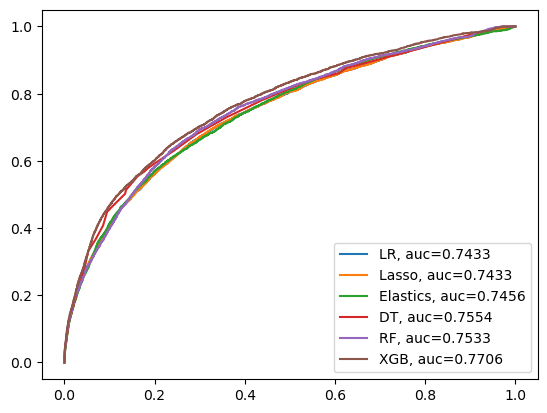

In [103]:
model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
for model_name in model_names:
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0.sav', 'rb'))
    preds = model.predict_proba(X_eval)
    preds = [x[1] for x in preds]
    fpr, tpr, thresholds = roc_curve(y_eval, preds, pos_label=1)
    auc = np.round(roc_auc_score(y_eval, preds), 4)
    plt.plot(fpr,tpr,label=model_name+", auc="+str(auc))
plt.legend(loc=4)
plt.show()

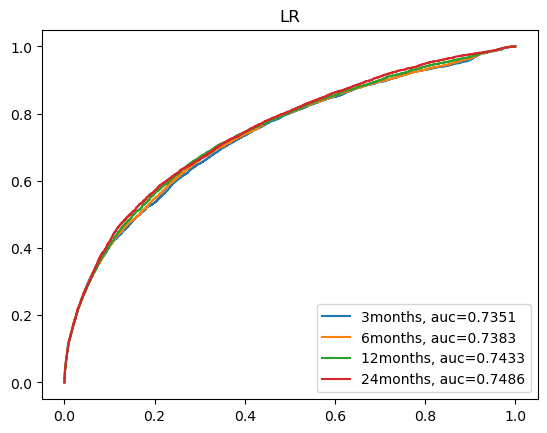

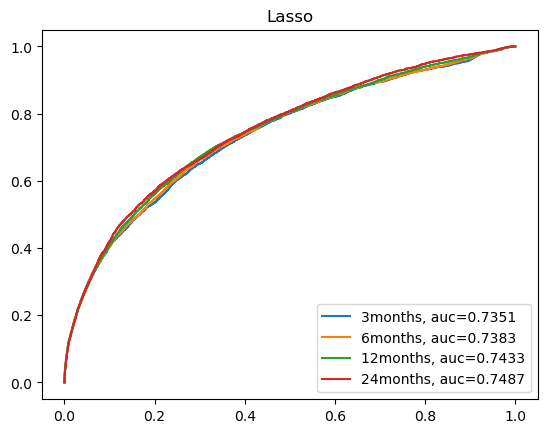

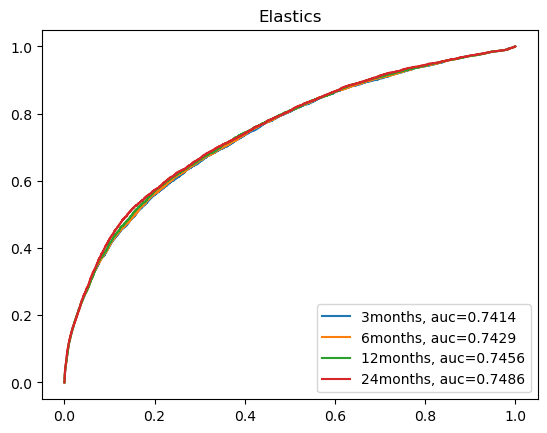

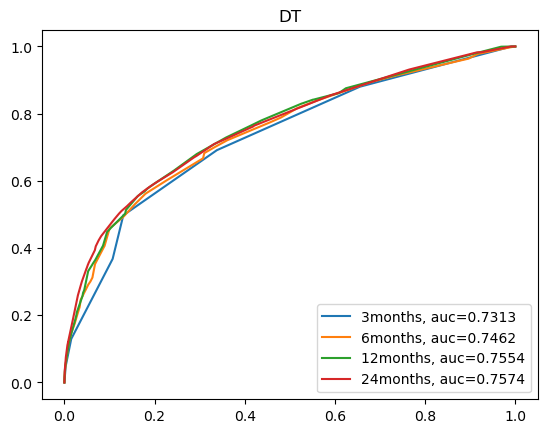

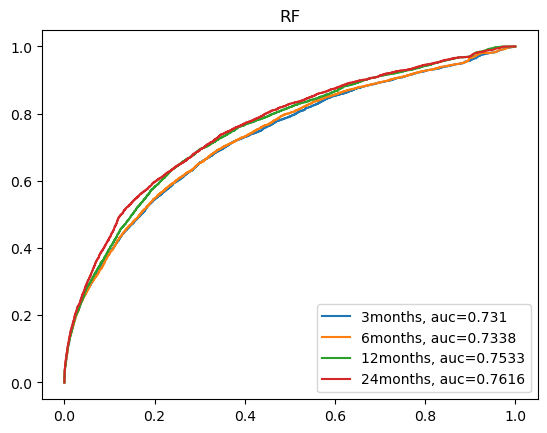

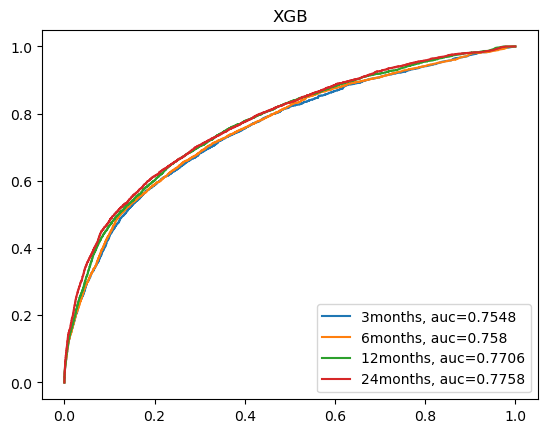

In [88]:
model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
for model_name in model_names:
    for outcome in target_outcomes:
        model = pickle.load(open('../Models_trainValEval/'+outcome+'/'+model_name+'0.sav', 'rb'))
        preds = model.predict_proba(X_eval)
        preds = [x[1] for x in preds]
        fpr, tpr, thresholds = roc_curve(y_eval, preds, pos_label=1)
        auc = np.round(roc_auc_score(y_eval, preds), 4)
        plt.plot(fpr,tpr,label=outcome+", auc="+str(auc))
    plt.legend(loc=4)
    plt.title(model_name)
    plt.show()

In [89]:
summary_result_val = []
summary_result_eval = []
summary_result_Wales = []
summary_result_Scotland = []
cols = ['model_name', 'outcome', 'auc', 'auprc']
for outcome in target_outcomes:
    for model_name in model_names:
        # print('======================================================================')
        print(model_name)
        model = pickle.load(open(model_folder+ outcome + '/'+ model_name + '0.sav', 'rb'))
        summary_result_eval.append((str(model_name),outcome,) + summariseResult (X_eval, y_eval, model) )
        summary_result_Wales.append((str(model_name),outcome,) + summariseResult (X_eval_Wales, y_eval_Wales, model) )       
        summary_result_Scotland.append((str(model_name),outcome,) + summariseResult (X_eval_Scotland, y_eval_Scotland, model) )       
        summary_result_val.append((str(model_name),outcome,) + summariseResult (X_internaleval, y_internaleval, model) )   

    
summary_result_eval = pd.DataFrame(summary_result_eval, columns=cols)
summary_result_eval['model_num'] = summary_result_eval.index

summary_result_Wales = pd.DataFrame(summary_result_Wales, columns=cols)
summary_result_Wales['model_num'] = summary_result_Wales.index

summary_result_Scotland = pd.DataFrame(summary_result_Scotland, columns=cols)
summary_result_Scotland['model_num'] = summary_result_Scotland.index

summary_result_internaleval = pd.DataFrame(summary_result_val, columns=cols)
summary_result_internaleval['model_num'] = summary_result_val.index
summary_result_internaleval['set'] = 'England'
summary_result_eval['set'] = 'Wales & Scotland'
summary_result_Wales['set'] = 'Wales'
summary_result_Scotland['set'] = 'Scotland'

combine = pd.concat([summary_result_internaleval, summary_result_eval, 
                     summary_result_Wales, summary_result_Scotland,
                    ])

LR
Lasso
Elastics
DT
RF
XGB
LR
Lasso
Elastics
DT
RF
XGB
LR
Lasso
Elastics
DT
RF
XGB
LR
Lasso
Elastics
DT
RF
XGB


Text(0.5, 29.140625000000007, 'Method')

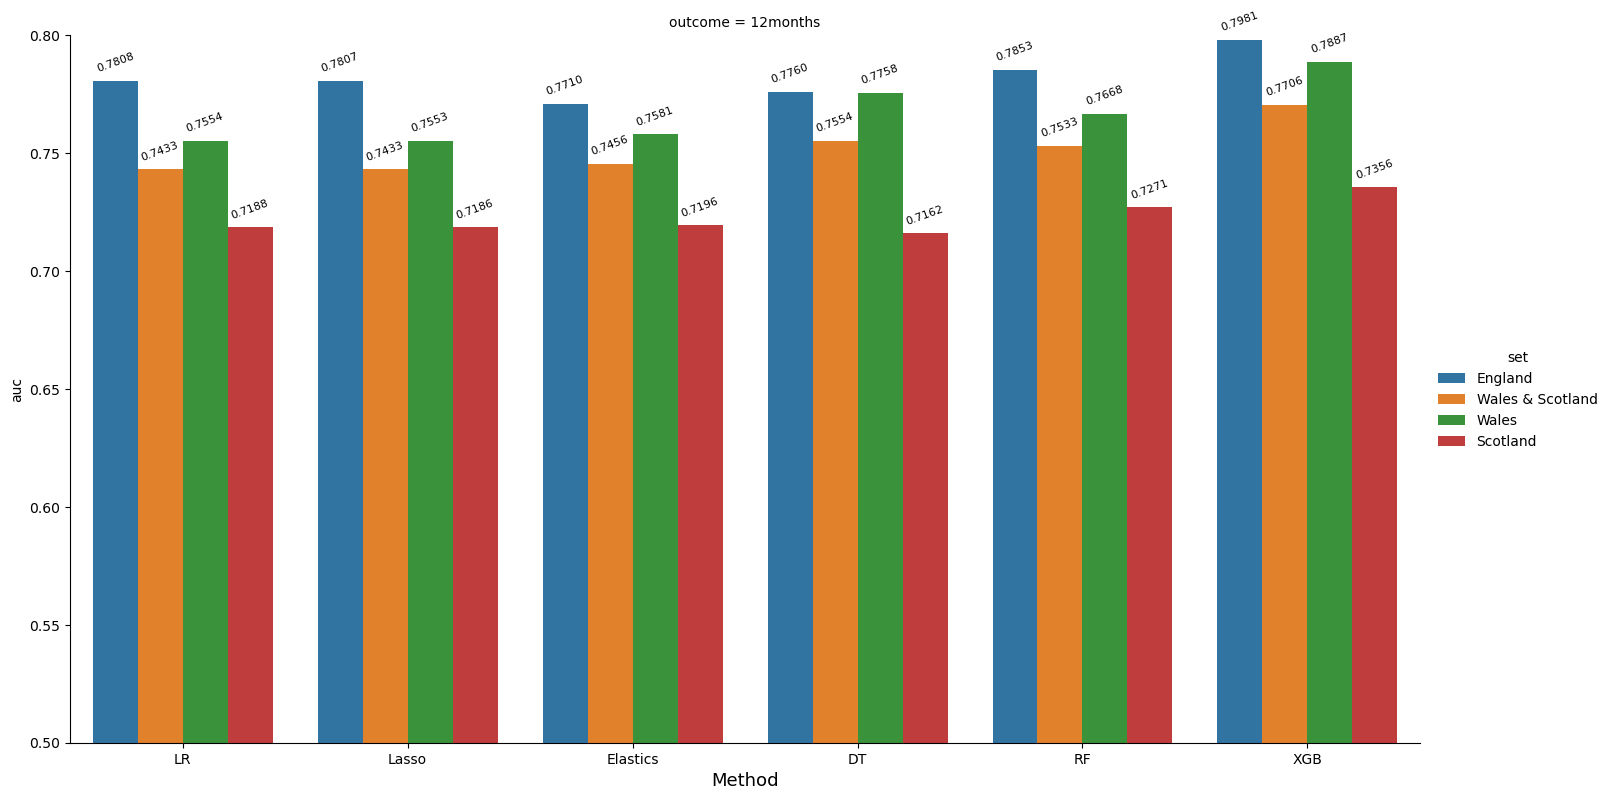

In [90]:
data = combine
data = combine[(combine.outcome=='12months')]
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'set',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=8,
            row='outcome',
            aspect=1.8,
            errorbar = None,)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.005, 
                '{0:.4f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=8)

ax.set_ylim(0.5, .8)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=13)

In [93]:
pickle.dump(combine, open('../Models/benchmarking_result.sav', 'wb'))

## Calibration

In [91]:
def summariseResultCalibration (testX, testY, model, threshold):
    preds = model.predict_proba(testX)
    preds = [0 if x[1] < threshold else 1 for x in preds]
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    aucscore = roc_auc_score(testY, preds)
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4), np.round(aucscore,4)



In [92]:
calibrationResult = []
model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
for model_name in model_names:
    for outcome in target_outcomes:
        model = pickle.load(open('../Models_trainValEval/'+outcome+'/'+model_name+'0.sav', 'rb'))
        preds = model.predict_proba(X_eval)
        preds = [x[1] for x in preds]
        fpr, tpr, thresholds = roc_curve(y_eval, preds)
        optimal_idx = np.argmax(tpr - fpr)# Find optimal probability threshold
        threshold = thresholds[optimal_idx]
        calibrationResult.append(((outcome, model_name, threshold)+summariseResultCalibration(X_eval, y_eval, model, threshold)))

cols = ['outcome', 'model', 'threshold', 'acc', 'sens', 'spec', 'balanced_acc', 'f1', 'ppv' , 'npv', 'auc']
pd.DataFrame(calibrationResult, columns = cols)

,outcome,model,threshold,acc,sens,spec,balanced_acc,f1,ppv,npv,auc
0,3months,LR,0.448248,0.6968,0.7164,0.6382,0.6773,0.5128,42.8620,85.5912,0.6773
1,6months,LR,0.440404,0.6898,0.6979,0.6655,0.6817,0.5176,42.3467,86.2262,0.6817
2,12months,LR,0.468532,0.7022,0.7175,0.6562,0.6868,0.5242,43.6392,86.2257,0.6868
3,24months,LR,0.524962,0.7247,0.7620,0.6129,0.6874,0.5268,46.1908,85.5181,0.6874
4,3months,Lasso,0.451068,0.6988,0.7202,0.6344,0.6773,0.5129,43.0489,85.5266,0.6773
5,6months,Lasso,0.446317,0.6910,0.7005,0.6627,0.6816,0.5175,42.4460,86.1680,0.6816
6,12months,Lasso,0.470462,0.7025,0.7184,0.6548,0.6866,0.5239,43.6669,86.1942,0.6866
7,24months,Lasso,0.547893,0.7373,0.7870,0.5883,0.6876,0.5283,47.9372,85.1503,0.6876
8,3months,Elastics,0.496684,0.7215,0.7622,0.5993,0.6808,0.5183,45.6577,85.0895,0.6808
9,6months,Elastics,0.501376,0.7194,0.7554,0.6114,0.6834,0.5214,45.4568,85.3625,0.6834


# Feature importance

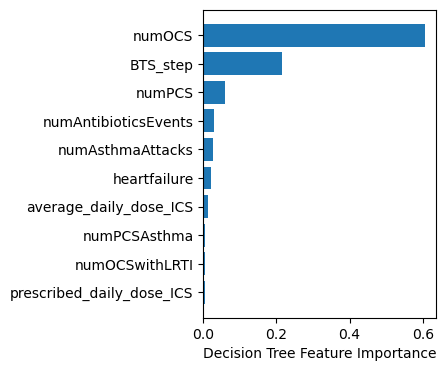

In [94]:
best_model_dt = pickle.load(open('../Models_trainValEval/12months/DT0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

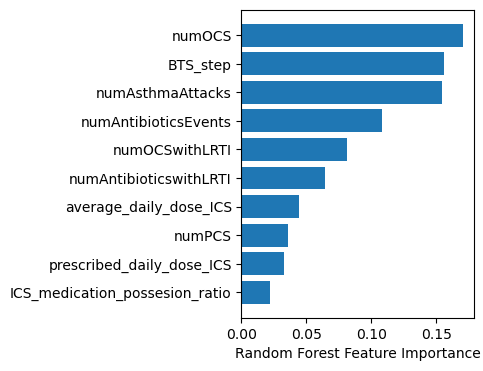

In [95]:
best_model_dt = pickle.load(open('../Models_trainValEval/12months/RF0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()
rftop10 = X.columns[sorted_idx][-10:]

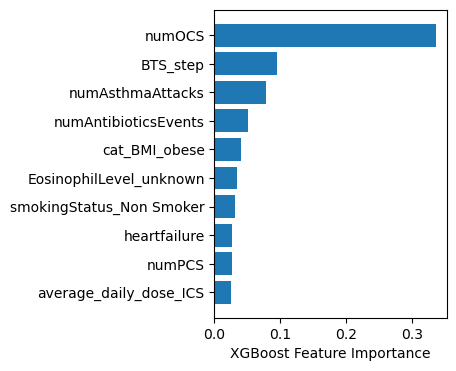

In [96]:
best_model_dt = pickle.load(open('../Models_trainValEval/12months/XGB0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.show()
xgbtop10 = X.columns[sorted_idx][-10:]

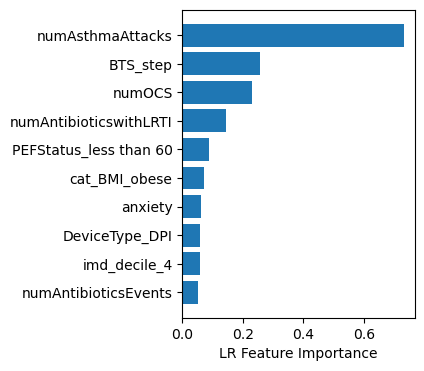

In [98]:
best_model_lr = pickle.load(open('../Models_trainValEval/12months/LR0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_lr.coef_[0].argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_lr.coef_[0][sorted_idx][-10:])
plt.xlabel("LR Feature Importance")
plt.show()
lrtop10 = X.columns[sorted_idx][-10:]

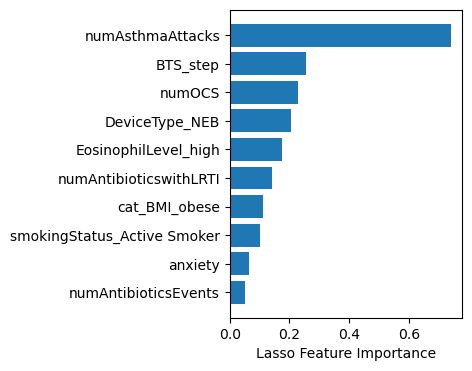

In [105]:
best_model_lasso = pickle.load(open('../Models_trainValEval/12months/Lasso0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_lasso.coef_[0].argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_lasso.coef_[0][sorted_idx][-10:])
plt.xlabel("Lasso Feature Importance")
plt.show()
lassotop10 = X.columns[sorted_idx][-10:]

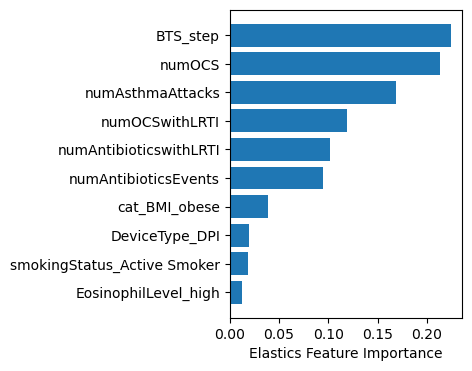

In [106]:
best_model_lasso = pickle.load(open('../Models_trainValEval/12months/Elastics0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_lasso.coef_[0].argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_lasso.coef_[0][sorted_idx][-10:])
plt.xlabel("Elastics Feature Importance")
plt.show()
elasticstop10 = X.columns[sorted_idx][-10:]

In [108]:
list(set(xgbtop10).intersection(set(lassotop10)))

['numAsthmaAttacks',
 'BTS_step',
 'cat_BMI_obese',
 'numAntibioticsEvents',
 'numOCS']

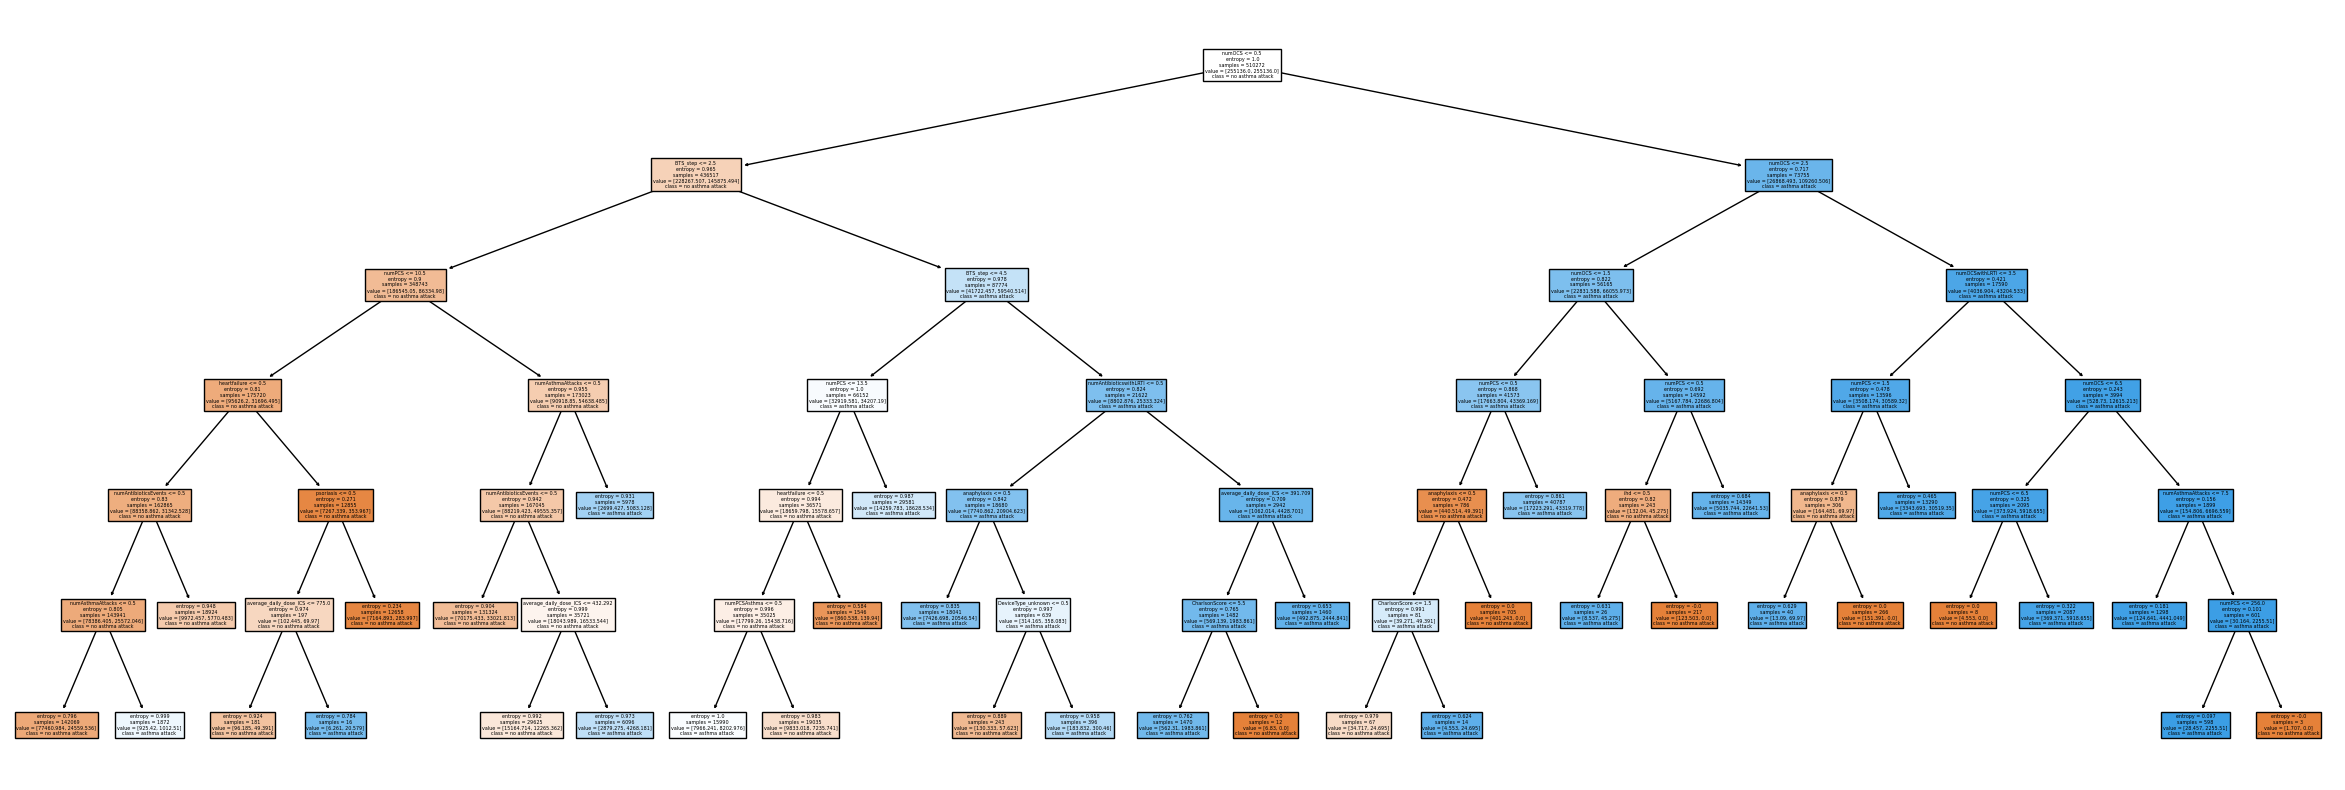

In [110]:
model2visualise = pickle.load(open('../Models_trainValEval/12months/DT0.sav', 'rb'))
prune_duplicate_leaves(model2visualise)
fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(model2visualise, 
                   feature_names=X.columns,  
                   class_names=['no asthma attack','asthma attack'],
                   filled=True,)
# plt.savefig('../FinalData/dt.png',format='png',bbox_inches = "tight")

## Minimum depth DT

In [112]:
%%time
#DT with minimum max of depth

#EXECUTE model training
X = trainingData[features_columns]
# X_test = evaluationData[features_columns]
target_outcome = '12months'

print(target_outcome)
y = trainingData[target_outcome]
y_test = evaluationData[target_outcome]
#Build models -> it can be commented if the models have been trained

# if os.path.isfile('../Models_trainValEval/dt_minimum_depth.sav'):
#     dt_model = pickle.load(open('../Models_trainValEval/dt_minimum_depth.sav', 'rb'))
# else:
dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=4, splitter='random', random_state=1234)
dt_model.fit(X, y)
pickle.dump(dt_model, open('../Models_trainValEval/dt_minimum_depth.sav', 'wb'))    
    

print(summariseResult (X_val, y_val, dt_model))
print(summariseResult (X_eval, y_eval, dt_model))
print(summariseResult (X_eval_Wales, y_eval_Wales, dt_model))
print("DT done")

12months
(0.7355, 0.4286)
(0.7187, 0.4801)
(0.7375, 0.5045)
DT done
CPU times: user 1.88 s, sys: 871 ms, total: 2.76 s
Wall time: 2.78 s


In [ ]:
prune_duplicate_leaves(dt_model)
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(dt_model, 
                   feature_names=X.columns,  
                   class_names=['no asthma attack','asthma attack'],
                   filled=True)
plt.savefig('../FinalData/dt_minimumdepth.png',format='png',bbox_inches = "tight")

In [ ]:
scaler = pickle.load(open('../Models_trainValEval/cont_scaler.pkl', 'rb'))
continuous_vars = ['age', 'CharlsonScore', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 
                   'numOCS', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI', 
                   'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents']

In [ ]:
DataOfInterest_cont = pd.DataFrame(scaler.inverse_transform(trainingData[continuous_vars]), columns=scaler.get_feature_names_out())

In [ ]:
VarOfInterest = ['numOCS', 'numPCS']
additionalVars = ['prescribed_daily_dose_ICS', 'numAntibioticsEvents', 'ICS_medication_possesion_ratio', 'numAsthmaAttacks', 'numAntibioticswithLRTI', 'age']
DataOfInterest = pd.concat((DataOfInterest_cont, trainingData[['BTS_step', 'imd_decile_0']+target_outcomes]), axis=1)
#solve little problem with inverse scaling:
DataOfInterest['numAsthmaAttacks'] = DataOfInterest.numAsthmaAttacks.apply(lambda x: 0 if x<1 else x)
DataOfInterest['numOCSwithLRTI'] = DataOfInterest.numOCSwithLRTI.apply(lambda x: 0 if x<1 else x)
DataOfInterest['numHospEvents'] = DataOfInterest.numHospEvents.apply(lambda x: 0 if x<1 else x)
DataOfInterest.head()

In [ ]:
scaler.feature_names_in_

In [ ]:
depth3_1 = [[0, 0, 0,
       0, 0,
       0.041, -1.086, 0, 0,
       0, 0, 0,
       0, 0, 0]]

depth3_2 = [[0, 0, 0,
       0, 0,
       0.583, -1.086, 0, 0,
       0, 0, 0,
       0, 0, 0]]

depth4_1 = [[0, -0.822, 0,
       0, 0,
       0.041, -0.23, 0, 0,
       0, 0, 0,
       2.493, 0, 0]]

depth4_2 = [[0, -0.822, 0,
       0, 0,
       0.583, -1.02, 0, 0,
       0, 0, 0,
       2.493, 0, 0]]

In [ ]:
scaler.inverse_transform(depth3_1)

In [ ]:
scaler.inverse_transform(depth3_2)

In [ ]:
scaler.inverse_transform(depth4_1)

In [ ]:
scaler.inverse_transform(depth4_2)

In [ ]:
DataOfInterest.CharlsonScore.hist()

In [ ]:
preds_dt = best_model_dt.predict(trainingData[features_columns])
preds_lasso = best_model_lasso.predict(trainingData[features_columns])
prediction_table = pd.DataFrame([trainingData['12months'], preds_dt, preds_lasso]).T
prediction_table.columns = ['y_true', 'y_pred_dt', 'y_pred_lasso']

In [ ]:
false_positive = prediction_table[(prediction_table.y_pred_dt==1) & (prediction_table.y_true!=prediction_table.y_pred_dt)]
false_negative = prediction_table[(prediction_table.y_pred_dt==0) & (prediction_table.y_true!=prediction_table.y_pred_dt)]
true_positive = prediction_table[(prediction_table.y_pred_dt==1) & (prediction_table.y_true==prediction_table.y_pred_dt)]
true_negative = prediction_table[(prediction_table.y_pred_dt==0) & (prediction_table.y_true==prediction_table.y_pred_dt)]

In [ ]:
print('True Pos')
print(DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']].describe())
print('-----------------------------------------------------------------------------------')
print('False Neg')
print(DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']].describe())
print('-----------------------------------------------------------------------------------')
# print('False Pos')
# print(DataOfInterest.iloc[false_positive.index][VarOfInterest+['BTS_step']].describe())
# print('-----------------------------------------------------------------------------------')
# print('True Neg')
# print(DataOfInterest.iloc[true_negative.index][VarOfInterest+['BTS_step']].describe())

In [ ]:
fig, ax = plt.subplots()
DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']].boxplot(ax=ax)
ax.set_ylim(-50,400)
plt.show()
print('-----------------------------------------------------------------------------------')
fig, ax = plt.subplots()
DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']].boxplot()
ax.set_ylim(-50,400)
plt.show()
print('-----------------------------------------------------------------------------------')
fig, ax = plt.subplots()
DataOfInterest.iloc[true_negative.index][VarOfInterest+['BTS_step']].boxplot()
ax.set_ylim(-50,400)
plt.show()

In [ ]:
print(DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']+additionalVars+['imd_decile_0']].describe())
print('-----------------------------------------------------------------------------------')
print(DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']+additionalVars+['imd_decile_0']].describe())
print('-----------------------------------------------------------------------------------')
print(DataOfInterest.iloc[true_negative.index][VarOfInterest+['BTS_step']+additionalVars+['imd_decile_0']].describe())

In [ ]:
DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']].sample(n=20, random_state=1234)

In [ ]:
DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']].sample(n=20, random_state=1234)

## Run models only on the subset of BTS == 1

In [ ]:
trainingDataSubset = trainingData[(trainingData.BTS_step < 7)]
validationDataSubset = validationData[(validationData.BTS_step < 7) ]
evaluationDataSubset = evaluationData[(evaluationData.BTS_step < 7)]
evaluationDataWalesSubset = evaluationDataWales[(evaluationDataWales.BTS_step < 7) ]
evaluationDataScotlandSubset = evaluationDataScotland[(evaluationDataScotland.BTS_step < 7)]

In [ ]:
#encode categorical data

# cat_vars = ['PEFStatus','EosinophilLevel']
onehot_vars = ['BTS_step']
# data_categorical = trainingData[cat_vars]
data_onehot = trainingDataSubset[onehot_vars]

# #ordinal encoder
# encoder = OrdinalEncoder(categories=[['not_recorded','less than 60', '60-80', 'more than 80'], ['unknown', 'normal', 'high']]).set_output(transform="pandas")
# data_encoded = encoder.fit_transform(data_categorical)
# pickle.dump(encoder, open('../Models/cat_encoder.pkl', 'wb'))
    
#one hot encoder
onehot_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
onehot_encoded = onehot_encoder.fit_transform(data_onehot)
# pickle.dump(onehot_encoder, open('../Models/onehot_encoder.pkl', 'wb'))

# trainingDataSubset = pd.concat([trainingDataSubset.drop(cat_vars, axis=1), data_encoded], axis=1)
trainingDataSubset = pd.concat([trainingDataSubset.drop(onehot_vars, axis=1), onehot_encoded], axis=1)

print('Data shape after encoding: ', trainingDataSubset.shape)

In [ ]:
#encode cat vars for validation and evaluation set
# data_val_categorical = validationData[cat_vars]
data_val_onehot = validationDataSubset[onehot_vars]
# data_eval_categorical = evaluationData[cat_vars]
data_eval_onehot = evaluationDataSubset[onehot_vars]
# data_eval_Wales_categorical = evaluationDataWales[cat_vars]
data_eval_Wales_onehot = evaluationDataWalesSubset[onehot_vars]
# data_eval_Scotland_categorical = evaluationDataScotland[cat_vars]
data_eval_Scotland_onehot = evaluationDataScotlandSubset[onehot_vars]

# encoder = pickle.load(open('../Models/cat_encoder.pkl', 'rb'))
# data_val_encoded = encoder.transform(data_val_categorical)
# data_eval_encoded = encoder.transform(data_eval_categorical)
# data_eval_Wales_encoded = encoder.transform(data_eval_Wales_categorical)
# data_eval_Scotland_encoded = encoder.transform(data_eval_Scotland_categorical)

# onehot_encoder = pickle.load(open('../Models/onehot_encoder.pkl', 'rb'))
onehot_val_encoded = onehot_encoder.transform(data_val_onehot)
onehot_eval_encoded = onehot_encoder.transform(data_eval_onehot)
onehot_eval_Wales_encoded = onehot_encoder.transform(data_eval_Wales_onehot)
onehot_eval_Scotland_encoded = onehot_encoder.transform(data_eval_Scotland_onehot)

# validationDataSubset = pd.concat([validationDataSubset.drop(cat_vars, axis=1), data_val_encoded], axis=1)
validationDataSubset = pd.concat([validationDataSubset.drop(onehot_vars, axis=1), onehot_val_encoded], axis=1)

# evaluationDataSubset = pd.concat([evaluationDataSubset.drop(cat_vars, axis=1), data_eval_encoded], axis=1)
evaluationDataSubset = pd.concat([evaluationDataSubset.drop(onehot_vars, axis=1), onehot_eval_encoded], axis=1)

# evaluationDataWalesSubset = pd.concat([evaluationDataWalesSubset.drop(cat_vars, axis=1), data_eval_Wales_encoded], axis=1)
evaluationDataWalesSubset = pd.concat([evaluationDataWalesSubset.drop(onehot_vars, axis=1), onehot_eval_Wales_encoded], axis=1)

# evaluationDataScotlandSubset = pd.concat([evaluationDataScotlandSubset.drop(cat_vars, axis=1), data_eval_Scotland_encoded], axis=1)
evaluationDataScotlandSubset = pd.concat([evaluationDataScotlandSubset.drop(onehot_vars, axis=1), onehot_eval_Scotland_encoded], axis=1)

print('Val data shape after encoding: ', validationDataSubset.shape)
print('Eval data shape after encoding: ', evaluationDataSubset.shape)
print('Evaluation data Wales shape: ', evaluationDataWalesSubset.shape)
print('Evaluation data Scotland shape: ', evaluationDataScotlandSubset.shape)

In [ ]:
trainingDataSubset.shape

In [ ]:
trainingDataSubset.columns

In [ ]:
features_columns.remove('BTS_step')
features_columns = features_columns + ['BTS_step_0.0', 'BTS_step_1.0', 'BTS_step_2.0',
                                       'BTS_step_3.0', 'BTS_step_4.0', 'BTS_step_5.0']
features_columns

In [ ]:
X_subset = trainingDataSubset[features_columns]
X_val_subset = validationDataSubset[features_columns]
X_eval_subset = evaluationDataSubset[features_columns]
X_eval_Wales_subset = evaluationDataWalesSubset[features_columns]
X_eval_Scotland_subset = evaluationDataScotlandSubset[features_columns]
target_outcomes = ['3months', '6months', '12months', '24months'] 

In [ ]:
X_subset.shape

In [ ]:
X_subset.shape[0]/trainingData.shape[0]

In [ ]:
%%time


#EXECUTE model training
summary_result_val_subset = []
summary_result_eval_subset = []
summary_result_Wales_subset = []
summary_result_Scotland_subset = []
cols = ['model_name', 'outcome', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
model_folder = '../Models_subsetBTS/'
fold = 0

for target_outcome in target_outcomes:
    models = pd.DataFrame(columns=['modelname', 'target_outcome', 'class_ratio'])
    print(target_outcome)
    y_subset = trainingDataSubset[target_outcome]
    y_val_subset = validationDataSubset[target_outcome]
    y_eval_subset = evaluationDataSubset[target_outcome]
    y_eval_Wales_subset = evaluationDataWalesSubset[target_outcome]
    y_eval_Scotland_subset = evaluationDataScotlandSubset[target_outcome]
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X_subset, y_subset, target_outcome, params_dict, model_folder, fold), columns=['modelname', 'target_outcome', 'class_ratio'])
    models = pd.concat([models,models_temp]).reset_index(drop=True)

    #evaluate model
    for modelname, target_outcome, classratio in models.values:
        # print('======================================================================')
        print(modelname)
        model = pickle.load(open(model_folder+ target_outcome + '/'+ modelname + '.sav', 'rb'))
        summary_result_eval_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_subset, y_eval_subset, model) )
        summary_result_Wales_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Wales_subset, y_eval_Wales_subset, model) )       
        summary_result_Scotland_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Scotland_subset, y_eval_Scotland_subset, model) )       
        summary_result_val_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_val_subset, y_val_subset, model) )       


summary_result_eval_subset = pd.DataFrame(summary_result_eval_subset, columns=cols)
summary_result_eval_subset['model_num'] = summary_result_eval_subset.index

summary_result_Wales_subset = pd.DataFrame(summary_result_Wales_subset, columns=cols)
summary_result_Wales_subset['model_num'] = summary_result_Wales_subset.index

summary_result_Scotland_subset = pd.DataFrame(summary_result_Scotland_subset, columns=cols)
summary_result_Scotland_subset['model_num'] = summary_result_Scotland_subset.index

summary_result_val_subset = pd.DataFrame(summary_result_val_subset, columns=cols)
summary_result_val_subset['model_num'] = summary_result_val_subset.index


In [ ]:
summary_result_val_subset['set'] = 'val'
summary_result_eval_subset['set'] = 'eval'
summary_result_Wales_subset['set'] = 'Wales'
summary_result_Scotland_subset['set'] = 'Scotland'

combine_subset = pd.concat([summary_result_val_subset, summary_result_eval_subset, 
                     summary_result_Wales_subset, summary_result_Scotland_subset,
                    ])

In [ ]:
data = combine_subset
# data = combine[combine.set!='Training Set']
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'set',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=5,
            row='outcome',
            aspect=3,
            errorbar = None,)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.005, 
                '{0:.4f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=8)

ax.set_ylim(0.55, 0.76)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=13)

In [ ]:
best_model_dt = pickle.load(open('../Models_subsetBTS/12months/DT0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X_subset.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()